In [32]:
import os
import urllib
import random
import warnings

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import seaborn as sns

from sklearn import preprocessing, grid_search
from sklearn.cross_validation import train_test_split
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest

from sklearn import neighbors
from sklearn.neighbors import NearestNeighbors
from statsmodels.robust.scale import mad


In [42]:
n_neighbors = 5
n_feature_kept = 500
param_fixed = {
    'loss': 'log',
    'penalty': 'elasticnet',
}
param_grid = {
}

In [3]:
%matplotlib inline
plt.style.use('seaborn-notebook')


In [4]:
# We're going to be building a 'TP53' classifier 
GENE = 'TP53'


In [5]:
if not os.path.exists('data'):
    os.makedirs('data')


In [6]:
url_to_path = {
    # X matrix
    'https://ndownloader.figshare.com/files/5514386':
        os.path.join('data', 'expression.tsv.bz2'),
    # Y Matrix
    'https://ndownloader.figshare.com/files/5514389':
        os.path.join('data', 'mutation-matrix.tsv.bz2'),
}

for url, path in url_to_path.items():
    if not os.path.exists(path):
        urllib.request.urlretrieve(url, path)


In [5]:
%%time
path = os.path.join('data', 'expression.tsv.bz2')
X = pd.read_table(path, index_col=0)


Wall time: 2min 15s


In [7]:
%%time
path = os.path.join('data', 'mutation-matrix.tsv.bz2')
Y = pd.read_table(path, index_col=0)


Wall time: 1min 57s


In [8]:
y = Y[GENE]


In [9]:
# The Series now holds TP53 Mutation Status for each Sample
y.head(6)


sample_id
TCGA-02-0047-01    0
TCGA-02-0055-01    1
TCGA-02-2483-01    1
TCGA-02-2485-01    1
TCGA-02-2486-01    0
TCGA-04-1348-01    1
Name: TP53, dtype: int64

In [19]:
# top samples
X.head(6)

,A1BG,A1CF,A2BP1,A2LD1,A2M,A2ML1,A4GALT,A4GNT,AAA1,AAAS,...,ZXDA,ZXDB,ZXDC,ZYG11A,ZYG11B,ZYX,ZZEF1,ZZZ3,psiTPTE22,tAKR
sample_id,,,,,,,,,,,,,,,,,,,,,
TCGA-02-0047-01,6.98,0.0,7.940,5.81,15.1,5.40,5.22,1.160,1.160,8.87,...,6.05,8.48,10.10,0.691,10.20,11.9,10.40,9.24,2.96,0.0
TCGA-02-0055-01,8.62,0.0,7.110,6.41,15.4,1.42,8.93,0.642,0.000,9.22,...,5.45,8.14,9.25,2.600,9.85,13.5,9.25,9.49,3.74,0.0
TCGA-02-2483-01,8.09,0.0,6.810,5.15,14.4,1.82,6.46,0.000,0.000,10.10,...,4.35,8.67,9.76,5.500,10.20,12.3,9.70,9.46,8.64,0.0
TCGA-02-2485-01,6.41,0.0,8.010,6.99,12.9,7.73,7.29,0.562,0.000,9.99,...,5.78,8.10,10.40,0.000,10.10,12.3,10.20,9.45,4.06,0.0
TCGA-02-2486-01,6.77,0.0,2.400,7.58,15.3,6.71,5.49,0.000,0.687,9.46,...,5.03,7.64,9.35,0.000,9.43,12.9,9.30,9.05,6.14,0.0
TCGA-04-1348-01,6.08,0.0,0.344,7.80,12.5,3.09,6.55,0.621,0.000,11.10,...,5.21,7.88,9.69,2.730,9.13,14.0,8.99,8.90,2.48,0.0


In [9]:
# Here are the percentage of tumors with NF1
y.value_counts(True)


0    0.655334
1    0.344666
Name: TP53, dtype: float64

# Set aside 10% of the data for testing

In [19]:
# Typically, this can only be done where the number of mutations is large enough
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=0)
'Size: {:,} features, {:,} training samples, {:,} testing samples'.format(len(X.columns), len(X_train), len(X_test))


'Size: 20,501 features, 6,935 training samples, 771 testing samples'

In [21]:
def fs_mad(x, y):
    """    
    Get the median absolute deviation (MAD) for each column of x
    """
    scores = mad(x) 
    return scores, np.array([np.NaN]*len(scores))

# select the top features with the highest MAD
feature_select = SelectKBest(fs_mad, k=n_feature_kept)


In [14]:
# set 1: use 10% of data to train to speed it up (flip train and test)
# note: this seems to be overfitting
X_test1, X_train, y_test1, y_train = train_test_split(X, y, test_size=0.1, random_state=0)
'Size: {:,} features, {:,} training samples, {:,} testing samples'.format(len(X.columns), len(X_train), len(X_test))


'Size: 20,501 features, 771 training samples, 6,935 testing samples'

In [15]:
%%time
for weights in ['uniform', 'distance']:
    # we create an instance of Neighbours Classifier and fit the data.
    clf = neighbors.KNeighborsClassifier(n_neighbors, weights=weights)
    clf.fit(X_train, y_train)  
    

Wall time: 2.83 s


In [16]:
%%time
y_pred_train = clf.predict(X_train)
y_pred_test = clf.predict(X_test)

def get_threshold_metrics(y_true, y_pred):
    roc_columns = ['fpr', 'tpr', 'threshold']
    roc_items = zip(roc_columns, roc_curve(y_true, y_pred))
    roc_df = pd.DataFrame.from_items(roc_items)
    auroc = roc_auc_score(y_true, y_pred)
    return {'auroc': auroc, 'roc_df': roc_df}

metrics_train = get_threshold_metrics(y_train, y_pred_train)
metrics_test = get_threshold_metrics(y_test, y_pred_test)


Wall time: 4min 26s


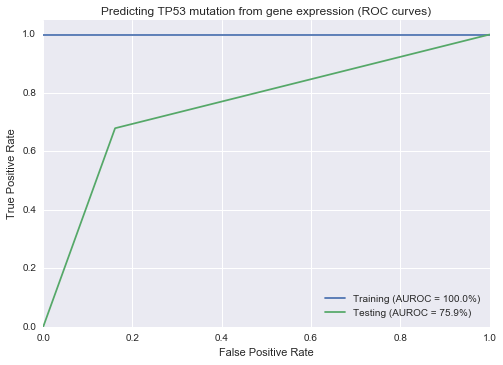

In [17]:
# Plot ROC
plt.figure()
for label, metrics in ('Training', metrics_train), ('Testing', metrics_test):
    roc_df = metrics['roc_df']
    plt.plot(roc_df.fpr, roc_df.tpr,
        label='{} (AUROC = {:.1%})'.format(label, metrics['auroc']))
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Predicting TP53 mutation from gene expression (ROC curves)')
plt.legend(loc='lower right');


In [43]:
# Include loss='log' in param_grid doesn't work with pipeline somehow
# set 2 seems to deliver better results
clf = neighbors.KNeighborsClassifier(n_neighbors,'uniform')

# joblib is used to cross-validate in parallel by setting `n_jobs=-1` in GridSearchCV
# Supress joblib warning. See https://github.com/scikit-learn/scikit-learn/issues/6370
warnings.filterwarnings('ignore', message='Changing the shape of non-C contiguous array')
clf_grid = grid_search.GridSearchCV(estimator=clf, param_grid=param_grid, n_jobs=-1, scoring='roc_auc')
pipeline = make_pipeline(
    feature_select,  # Feature selection
    StandardScaler(),  # Feature scaling
    clf_grid)

In [44]:
%%time
# Fit the model (the computationally intensive part)
pipeline.fit(X=X_train, y=y_train)
best_clf = clf_grid.best_estimator_
feature_mask = feature_select.get_support()  # Get a boolean array indicating the selected features


Wall time: 24.4 s


In [47]:
%%time
y_pred_train = pipeline.predict(X_train)
y_pred_test = pipeline.predict(X_test)

def get_threshold_metrics(y_true, y_pred):
    roc_columns = ['fpr', 'tpr', 'threshold']
    roc_items = zip(roc_columns, roc_curve(y_true, y_pred))
    roc_df = pd.DataFrame.from_items(roc_items)
    auroc = roc_auc_score(y_true, y_pred)
    return {'auroc': auroc, 'roc_df': roc_df}

metrics_train = get_threshold_metrics(y_train, y_pred_train)
metrics_test = get_threshold_metrics(y_test, y_pred_test)


Wall time: 52 s


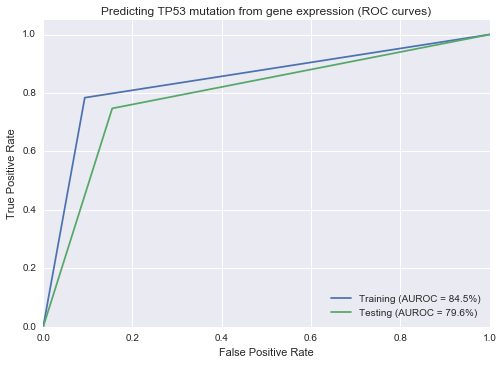

In [48]:
# Plot ROC
plt.figure()
for label, metrics in ('Training', metrics_train), ('Testing', metrics_test):
    roc_df = metrics['roc_df']
    plt.plot(roc_df.fpr, roc_df.tpr,
        label='{} (AUROC = {:.1%})'.format(label, metrics['auroc']))
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Predicting TP53 mutation from gene expression (ROC curves)')
plt.legend(loc='lower right');